# 미션 5 개요
흉부 X-Ray 사진을 바탕으로 폐렴 환자를 구분하는 작업을 수행.

X-Ray 사진을 입력으로 받아 폐렴 여부를 구분하는 분류(Classsification) 모델을 만드는 것.

다양한 이미지 전처리 및 증강 기법과 Transfer Learning과 Fine-Tuning 기법을 실험해보고, 모델의 성능을 평가.

데이터
 - Chest X-Ray Images(Pneumonia)
     - train : 훈련 데이터
     - val : 검증 데이터
     - test : 테스트 데이터

- Transfer Learning 적용
- Fine-Tuning 적용
   - Frozen 모델, Partial Fine-Tuning, Full Fine-Tuning 비교/실험
   - 모델별 성능 비교, 분석 결과 도출
- 모델 성능 평가
   - 평가 지표(Accuracy, Precision, Recall, F1-score 등) 활용 모델 성능 분석 비교

# 환경설정

In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2

from pathlib import Path
import kagglehub

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torchvision.models as models
from torchvision import models
from torchinfo import summary

from PIL import Image, ImageEnhance, ImageFilter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.v2 as v2
import math
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import copy
from datetime import datetime


In [4]:
print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

os.makedirs("pth", exist_ok=True)

PyTorch: 2.7.1
MPS available: True
mps


## 함수화

In [24]:
def train_model(model, loss_fn, optimizer, train_loader, val_loader, device, num_epochs=100, model_name="model"):
    best_val_loss = float('inf')
    best_state = None
    history = {'train_loss':[], 'val_loss': [], 'val_accuracy': [], 'val_f1': []}

    for epoch in range(num_epochs):
        # training
        model.train()
        running_loss = 0.0
        for step, (X, y) in enumerate(train_loader, 1):
            X, y = X.to(device), y.to(device)

            preds = model(X)
            loss = loss_fn(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if step % 50 == 0:
                print(f"[{model_name}] Epoch {epoch} step {step} train_loss = {loss.item():.6f}")

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # validation
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss = loss_fn(preds, y)
                val_losses.append(loss.item())

                # accuracy 계산
                _, predicted = torch.max(preds, 1)
                val_correct += (predicted == y).sum().item()
                val_total += y.size(0)

                # F1 score 계산
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        val_accuracy = val_correct / val_total
        avg_val_loss = sum(val_losses) / len(val_losses)

        # F1 score 계산
        val_f1 = f1_score(all_labels, all_preds, average='weighted') #weighted: 클래스 비율 반영
                                                                    # micro: 전체 샘플에 대한 클래스별 정밀도와 재현율의 평균
        
        history['val_accuracy'].append(val_accuracy)
        history['val_loss'].append(avg_train_loss)
        history['val_f1'].append(val_f1)

        print(f"[{model_name}] Epoch {epoch} train_loss = {loss.item():.6f} val_loss={avg_val_loss:.6f} val_accuracy={val_accuracy:.6f} val_f1={val_f1:.6f}")

        # best model saved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = copy.deepcopy(model.state_dict())
            loss_name = loss_fn.__class__.__name__
            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            fname = f"./pth/{model_name}_{loss_name}_{ts}_best_epoch{epoch:03d}_val{avg_val_loss:.6f}.pth"
            torch.save(best_state, fname)
            print(f"↳ New best model saved: {fname}")

    return history


## 데이터 불러오기

In [5]:
# KaggleHub 캐시를 현재 노트북 폴더 안에 .kagglehub_cache 로 고정
cache_dir = Path.cwd() / ".kagglehub_cache"
cache_dir.mkdir(parents=True, exist_ok=True)
os.environ["KAGGLEHUB_CACHE"] = str(cache_dir)

print(cache_dir)

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)


/Users/leeyoungho/develop/ai_study/mission/mission6/.kagglehub_cache
Path to dataset files: /Users/leeyoungho/develop/ai_study/mission/mission6/.kagglehub_cache/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [7]:
# 폴더 경로 설정
train_dir = os.path.join(path, "chest_xray", "train")
val_dir = os.path.join(path, "chest_xray", "val")
test_dir = os.path.join(path, "chest_xray", "test")

## transform 만들기

In [26]:
crop_h, crop_w = 224, 224 #ResNet18 기본 이미지 크기

# 데이터 전처리 정의
data_transforms = {
    'train': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.RandomCrop((200, 200)),          # 랜덤 크롭 (200x200)
        v2.RandomRotation(20),              # 랜덤 회전 (-20도 ~ 20도)
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ]),
    'val': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ]),
    'test': v2.Compose([
        v2.Resize((crop_h, crop_w)),        # 이미지 크기 조정
        v2.ToTensor(),                       # 텐서로 변환
        v2.Normalize([0.5], [0.5])          # 정규화
    ])
}


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## dataset 만들기

In [27]:
# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

## dataloader 만들기

In [28]:
# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 클래스 확인
class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


# 모델

## Pretrained 모델 사용

In [29]:
pretrained_model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

In [30]:
summary(pretrained_model, (1, 3, 224, 224), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

## features freeze, classifier 교체

### 1. 분류기 교체 (2클래스)

In [31]:
num_ftrs = pretrained_model.fc.in_features  # ImageNet용 ResNet18은 nn.Linear(512, 1000) 구조 -> num_ftrs = 512
pretrained_model.fc = nn.Linear(num_ftrs, 2)  # 클래스 수 = 2 (NORMAL, PNEUMONIA) # 마지막 FC layer를 512->2로 변경
pretrained_model = pretrained_model.to(device)


### 2. features freeze (가중치 고정)

In [32]:
for param in pretrained_model.parameters():
    param.requires_grad = False  # 모든 파라미터 freeze

for param in pretrained_model.fc.parameters():
    param.requires_grad = True   # 분류기만 학습

### 3. 손실함수, 옵티마이저 정의

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.fc.parameters(), lr=1e-3)

### 4. train

In [34]:
history = train_model(
    pretrained_model,           # 모델
    criterion,                  # 손실 함수
    optimizer,                  # 옵티마이저
    train_loader,               # 학습 데이터로더
    val_loader,                 # 검증 데이터로더
    device,                     # 디바이스 (cpu/mps/cuda)
    num_epochs=10,              # 에폭 수 (원하는 만큼)
    model_name="resnet18_freeze" # 저장 파일명 접두사
)

[resnet18_freeze] Epoch 0 step 50 train_loss = 0.371755
[resnet18_freeze] Epoch 0 step 100 train_loss = 0.374993
[resnet18_freeze] Epoch 0 step 150 train_loss = 0.191456
[resnet18_freeze] Epoch 0 train_loss = 0.456418 val_loss=0.456418 val_accuracy=0.812500 val_f1=0.811765
↳ New best model saved: ./pth/resnet18_freeze_CrossEntropyLoss_20250625_104528_best_epoch000_val0.456418.pth
[resnet18_freeze] Epoch 1 step 50 train_loss = 0.160427
[resnet18_freeze] Epoch 1 step 100 train_loss = 0.153616
[resnet18_freeze] Epoch 1 step 150 train_loss = 0.376929
[resnet18_freeze] Epoch 1 train_loss = 0.391760 val_loss=0.391760 val_accuracy=0.812500 val_f1=0.811765
↳ New best model saved: ./pth/resnet18_freeze_CrossEntropyLoss_20250625_104629_best_epoch001_val0.391760.pth
[resnet18_freeze] Epoch 2 step 50 train_loss = 0.307699
[resnet18_freeze] Epoch 2 step 100 train_loss = 0.141953
[resnet18_freeze] Epoch 2 step 150 train_loss = 0.128451
[resnet18_freeze] Epoch 2 train_loss = 0.425938 val_loss=0.42593

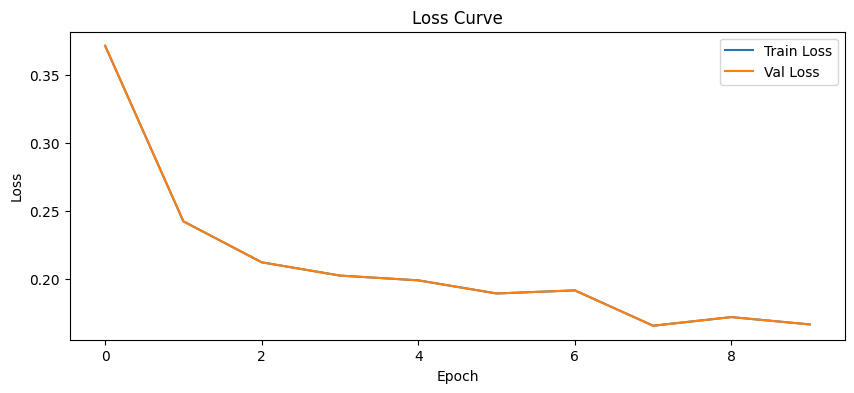

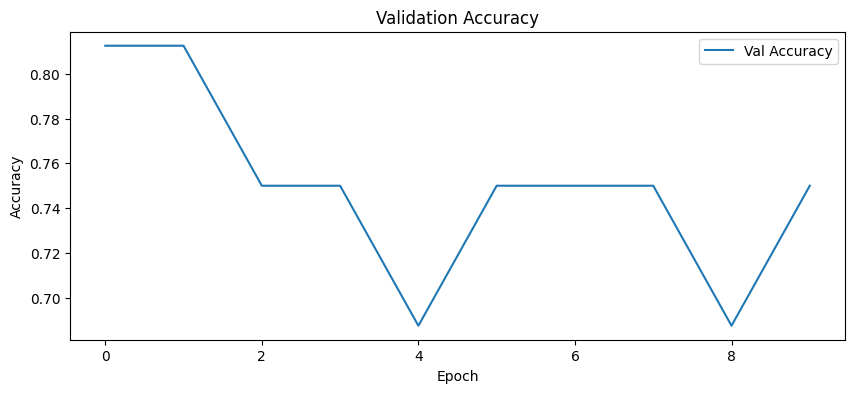

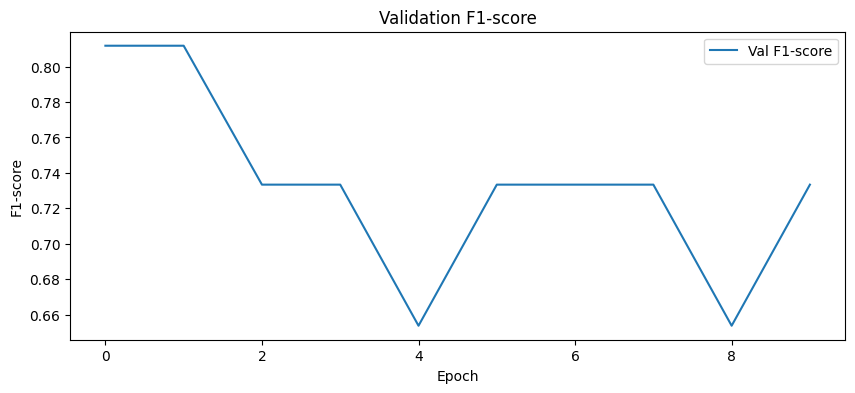

In [36]:
# 1. Loss 그래프
plt.figure(figsize=(10,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 2. Accuracy 그래프
plt.figure(figsize=(10,4))
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 3. F1-score 그래프
plt.figure(figsize=(10,4))
plt.plot(history['val_f1'], label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score')
plt.legend()
plt.show()